# PROJECT 4 - Advanced Lane Finding

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

import math



%matplotlib inline

## Camera Calibration


camera_cal/calibration1.jpg
camera_cal/calibration2.jpg
camera_cal/calibration3.jpg
camera_cal/calibration4.jpg
camera_cal/calibration5.jpg
camera_cal/calibration6.jpg
camera_cal/calibration7.jpg
camera_cal/calibration8.jpg
camera_cal/calibration9.jpg
camera_cal/calibration10.jpg
camera_cal/calibration11.jpg
camera_cal/calibration12.jpg
camera_cal/calibration13.jpg
camera_cal/calibration14.jpg
camera_cal/calibration15.jpg
camera_cal/calibration16.jpg
camera_cal/calibration17.jpg
camera_cal/calibration18.jpg
camera_cal/calibration19.jpg
camera_cal/calibration20.jpg
Number of images used for calibration:  17


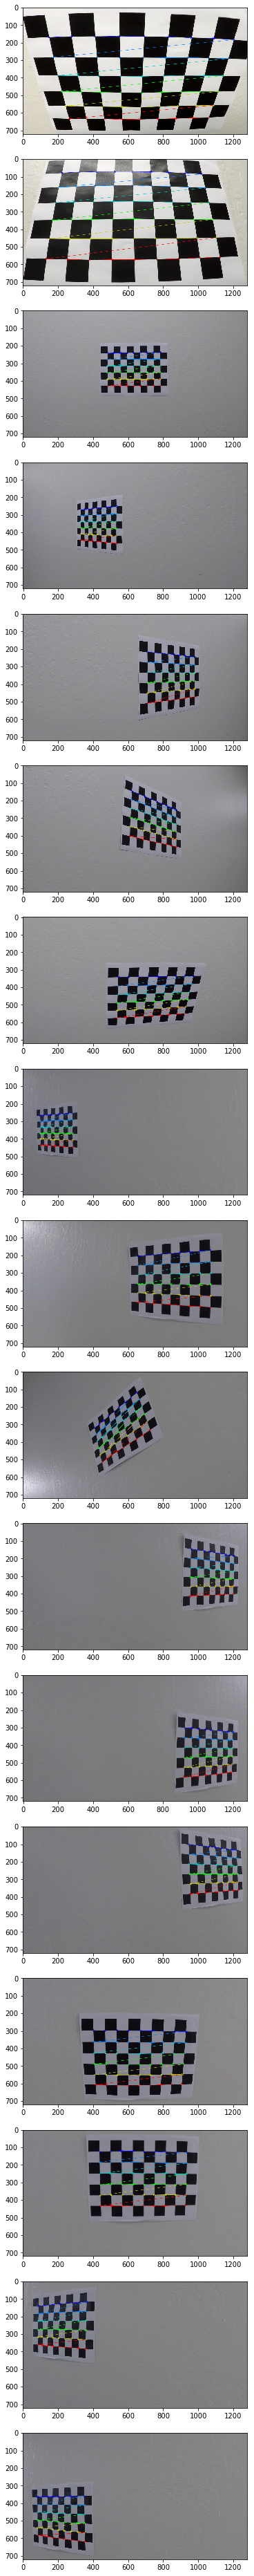

In [2]:
### CAMERA CALIBRATION

nx = 9 # Number of inside corners in x
ny = 6 # Number of inside corners in y

images = []

count = 0
for i in range(20):
    image_name = 'camera_cal/calibration' + str(count+1) + '.jpg'
    images.append(image_name)
    #print (image_name)
    count = count + 1


objpoints = []
imgpoints = []

objp = np.zeros((nx*ny, 3), np.float32)

objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x and y coordinates

f = plt.figure(1)
f.set_figheight(80)
f.set_figwidth(80)

print ('')

count = 0
for fname in images:
    print (fname)
    img = mpimg.imread(fname)

    
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray_image, (nx,ny), None)
    
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        plt.subplot(20,1,count + 1)
        count = count + 1
        plt.imshow(img)
        
print("Number of images used for calibration: ", count)

## Functions

In [3]:
### COLLECT AND SAVE FRAMES FROM VIDEO 

def video_to_frames(video, path_output_dir):
    # extract frames from a video and save to directory as 'x.png' where 
    # x is the frame index
    pipeline_images = []
    vidcap = cv2.VideoCapture(video)
    count = 0
    while vidcap.isOpened():
        success, image = vidcap.read()
        if success:
            cv2.imwrite(os.path.join(path_output_dir, 'image%d.jpg') % count, image)
            count += 1
            image_string = 'image%d.jpg' %count
            pipeline_images.append(image_string) #list of images in ascending order
        else:
            break
    cv2.destroyAllWindows()
    vidcap.release()
    return pipeline_images

In [4]:
### CORRECTION OF DISTORTION

def cal_undistort(img, objpoints, imgpoints):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray_img.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist, mtx, dist

In [5]:
### GRADIENT THRESHOLDS

# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def hls_select2(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,0]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

#  The Sobel Threshold
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[0])] = 1

    # Return the result
    return grad_binary

# Magnitude of the gradient
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return mag_binary

# Direction of the Gradient threshold
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image

    return dir_binary

In [6]:
###

def select_yellow(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower = np.array([20,60,60])
    upper = np.array([38,174, 250])
    mask = cv2.inRange(hsv, lower, upper)

    return mask

def select_white(image):
  lower = np.array([202,202,202])
  upper = np.array([255,255,255])
  mask = cv2.inRange(image, lower, upper)

  return mask

In [7]:
### COMBINED THRESHOLD

# This function combines the previous types of thresholds
def My_threshold(warped_im, ksize=3, Plot=False):
    
    R = warped_im[:,:,0]
    
    thresh = (220, 255)
    binary = np.zeros_like(R)
    binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(warped_im, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    #hls_binary = hls_select(warped_im, thresh=(120, 255))
    #grady = abs_sobel_thresh(warped_im, orient='y', sobel_kernel=3, thresh=(0, 255))
    #mag_binary = mag_thresh(warped_im, sobel_kernel=7, mag_thresh=(20, 255))
    #dir_binary = dir_threshold(warped_im, sobel_kernel=ksize, thresh=(1.0,1.5))
    """
    # Combine Thresholds    
    combined = np.zeros_like(gradx)
    combined[(gradx == 1) ] = 1
    combined[(mag_binary == 1)] = 1
    combined[(grady == 1)] = 0
    combined[(binary == 1)] = 1
    """
    
    # Apply each of the thresholding functions
    yellow = select_yellow(warped_im)
    white = select_white(warped_im)

    # Combine Thresholds    
    combined = np.zeros_like(yellow)
    combined[(binary == 1)] = 1
    combined[(gradx == 1) ] = 1
    combined[(yellow >= 1) ] = 1
    combined[(white >= 1)] = 1
    
    if Plot == True:
        histogram = np.sum(combined[combined.shape[0]//2:,:], axis=0)
        
        f, (ax1,ax2) = plt.subplots(1,2, figsize = (20,10))

        ax1.set_title('Binary Image')
        ax1.imshow(combined, cmap='gray')
        ax2.set_title('Histogram')
        ax2.plot(histogram)  
    
    return combined

In [8]:
### PERSPECTIVE TRANSFORM
def warp(img,A,B,C,D):
    img_size = (img.shape[1], img.shape[0])

    src = np.float32([A,B,C,D])
    #dst = np.float32([[350, 50],[350, B[1]], [950,C[1]], [950, 50]])
    dst = np.float32([[B[0]-30, 50],[B[0]-30, B[1]], [C[0]+30,C[1]], [C[0]+30, 50]])

    # Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src,dst)

    # Inverse
    Minv = cv2.getPerspectiveTransform(dst,src)

    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, Minv

In [9]:
### FINDING lINES
def finding_the_Lines(undist_image, binary_warped, Minv,
                      first_frame=True,
                      previous_lane_image=None,
                      previous_lane_detected=False,
                      previous_left_fit = None,
                      previous_right_fit=None,                      
                      plot=False):
    
    # undist_image: Undistorted image               
    # binary_warped: Binary warped image
    # first_frame: If the frame is the first generated (True or False)
    # previous_lane_image: The previous inverse warped image with the lane drawn
    # previous_lane_detected: If the frame the previous lane was detected (True or False)
    # previous_left_fit: Previous left fit array to not blind search
    # previous_right_fit: Previous left fit array to not blind search       
    # plot: Plot the images fo each step (True of False)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the width of the windows +/- margin
    margin = 130
    
    newwarp = previous_lane_image
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
   
    
    if ( (first_frame == True) | (previous_lane_detected == False) ):

        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
        
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255


        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)

        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Set minimum number of pixels found to recenter window
        minpix = 50

        ##########
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
    
    
        # IF LANE FAIL
        if ((len(lefty) == 0) | (len(leftx) == 0 ) | (len(rightx) == 0 ) | (len(righty) == 0 )):
            detected = False
            # Combine the result with the original image
            result3 = cv2.addWeighted(undist_image, 1, previous_lane_image, 0.3, 0)
            left_fit = None
            right_fit = None 

        else:
            detected = True

            # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
           
    else:
        left_fit = previous_left_fit
        right_fit = previous_right_fit     
        
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
                             

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
            
        if ((len(lefty) == 0) | (len(leftx) == 0 ) | (len(rightx) == 0 ) | (len(righty) == 0 )):
            detected = False
            # Combine the result with the original image
            result3 = cv2.addWeighted(undist_image, 1, previous_lane_image, 0.3, 0)
            left_fit = None
            right_fit = None
            
        else:
            detected = True
            # Fit a second order polynomial to each
            left_fit = np.polyfit(lefty, leftx, 2)
            right_fit = np.polyfit(righty, rightx, 2)
                
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    
    if detected == True:

        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


        ### Final Image - Drawing
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        
        # Check number of pixels of each lane
        i = 0
        ii = 0
        for j in nonzero[1]:
            if j < 400: # nonzero pixels before x = 400
                i+=1
            if j > 800: # nonzero pixels after x = 800
                ii+=1

        # If the non zeros pixels are few points in one of the two lines
        if ((i < 1500) | (ii < 1500)):
            detected = False # force blind search next time
            left_fit = None
            right_fit = None
            
        # If the nonzeros pixels are very few points
        if (((i < 700) & (i > 45000)) | ((ii < 700) & (ii > 45000))):
            result3 = cv2.addWeighted(undist_image, 1, previous_lane_image, 0.3, 0)
        else:            
            # Warp the blank back to original image space using inverse perspective matrix (Minv)
            newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))       
            ### FINAL IMAGE IF detected = True
            # Combine the result with the original image
            result3 = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)  
        
    # Plot 3 images    
    if plot == True:
        f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (16,8))

        ### Figure 1
        ax1.imshow(out_img)
        ax1.plot(left_fitx, ploty, color='yellow')
        ax1.plot(right_fitx, ploty, color='yellow')
        ax1.set_xlim([0, 1280])
        ax1.set_ylim([720, 0])

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)

        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        result1 = out_img
        ax1.set_title('Finding the Lines')
        ax1.imshow(result1)
        ### 


        ### Figure 2
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result2 = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        ax2.set_title('Draw the finding Lines')
        ax2.imshow(result2)
        ax2.plot(left_fitx, ploty, color='yellow')
        ax2.plot(right_fitx, ploty, color='yellow')
        ax2.set_xlim([0, 1280])
        ax2.set_ylim([720, 0])

        ###

        # Figure 3
        ax3.set_title('Final result')
        ax3.imshow(result3)
            
    
    final_processed_frame = result3
    
    xm_per_pix = 3.7/700
    
    if len(lefty) > 1 and len(righty) > 1:
        lane_offset = (640 - (left_fitx[-1]+right_fitx[-1])/2)*xm_per_pix
    else:
        lane_offset = 0
        
    return final_processed_frame, newwarp, lane_offset, detected, left_fit, right_fit, left_fitx, right_fitx, ploty



In [10]:
### CURVATURE MEASURE

def measure_curve(leftx,rightx,ploty):
    
    # y_eval is in bottom of the image   
    y_eval = np.max(ploty)
    bottom_index = len(ploty) - 1
    
    #Convert x,y pixels to meters
    ym_per_pix = 30/len(ploty)#meters per pixel in y dimension
    lane_width = np.absolute(leftx[bottom_index] - rightx[bottom_index])
    xm_per_pix = 3.7/lane_width #meters per pixel in x dimension
    
    #Fit new polynominals to x,y 
    left_fit_new = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_new = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    #Calculate new radius of curvature

    left_curverad = ((1 + (2*left_fit_new[0]*y_eval*ym_per_pix + left_fit_new[1])**2)**1.5) / np.absolute(2*left_fit_new[0])
    right_curverad = ((1 + (2*right_fit_new[0]*y_eval*ym_per_pix + right_fit_new[1])**2)**1.5) / np.absolute(2*right_fit_new[0])
    #print radius of curvature in meters
    
    curverad = (left_curverad, right_curverad)
    return curverad

## Test with two images

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


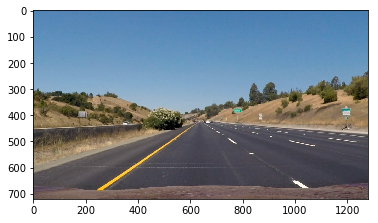

In [11]:
### TEST 1

#reading an image
image = mpimg.imread('test_images/straight_lines1.jpg')


#printing out 
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  

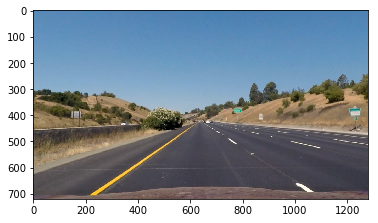

In [12]:
# undistortion image

undist1, mtx1, dist1 = cal_undistort(image, objpoints, imgpoints)
plt.imshow(undist1) 

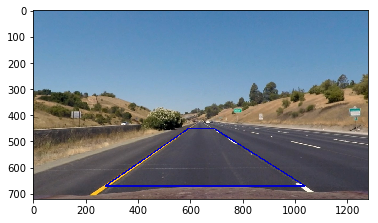

In [13]:
### Area adjustment
imshape = undist1.shape
image_copy = np.copy(undist1)


# VERTICES

#       A  D
#    B        C

"""
A = [580, 460]
B = [275, imshape[0] - 50]
C = [imshape[1]-240,imshape[0] - 50]
D = [imshape[1] - 580, 460]
"""

A = [595, 450]
B = [275, imshape[0] - 50]
C = [imshape[1]-240,imshape[0] - 50]
D = [imshape[1] - 590, 450]

vertices = np.array([[A, B, C, D]], dtype=np.int32)

image_draw = cv2.polylines(image_copy, vertices, 255, [0,0,200], thickness=3,  lineType=4)

plt.imshow(image_draw) 

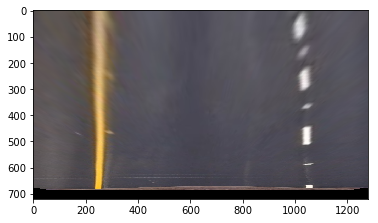

In [14]:
warped_im1, Minv1 = warp(undist1,A,B,C,D)
plt.imshow(warped_im1) 

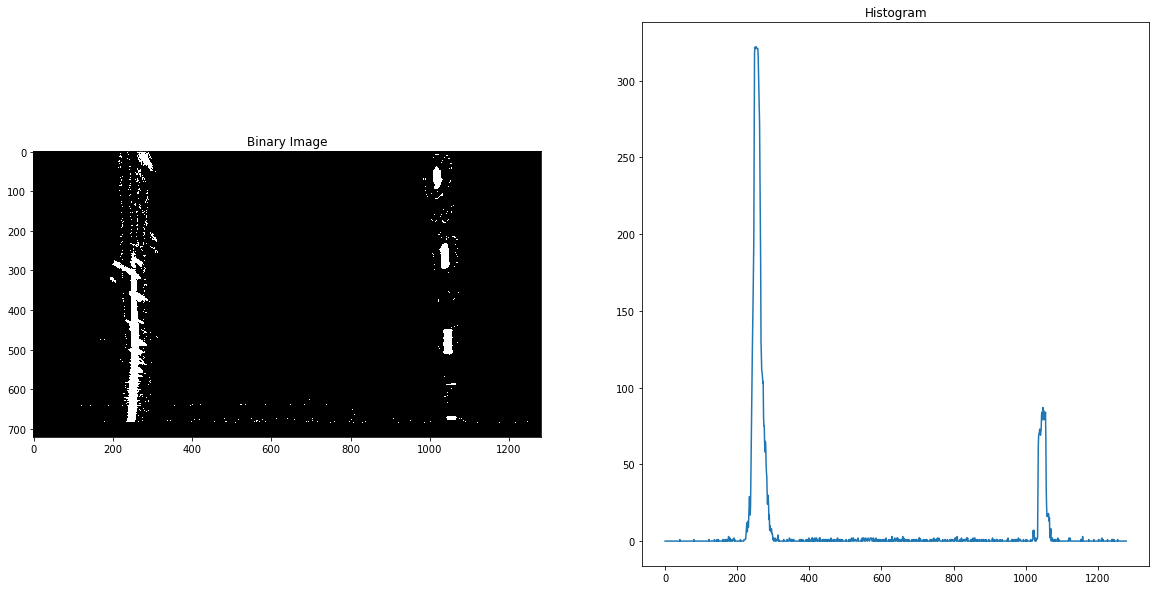

In [15]:
binary_warped1 = My_threshold(warped_im1, ksize=3, Plot=True)

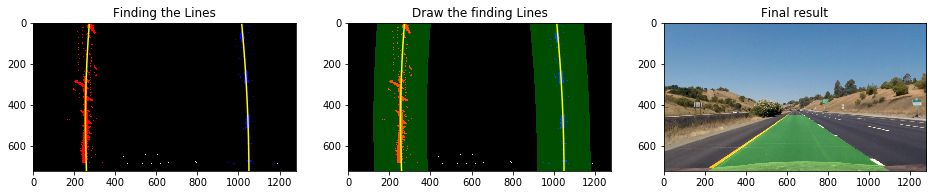

In [16]:
Test_result = finding_the_Lines(undist1, binary_warped1, Minv1, plot=True)

-0.0789667060903


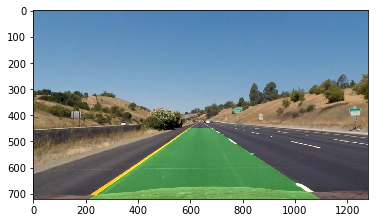

In [17]:
print (Test_result[2])
plt.imshow(Test_result[0])

In [18]:
### OFFSET AND CURVATURE


# OFFSET
print ("Lane offset: ", Test_result[2])
print (" ")


# CURVATURE

curverad = measure_curve(Test_result[-3],Test_result[-2],Test_result[-1])

print ('Radius of curvature is in meters: ')
print ('Left Line:    ', curverad[0], 'm')
print ('Right Line:   ', curverad[1], 'm')

Lane offset:  -0.0789667060903
 
Radius of curvature is in meters: 
Left Line:     2266.5479746 m
Right Line:    2948.78890325 m


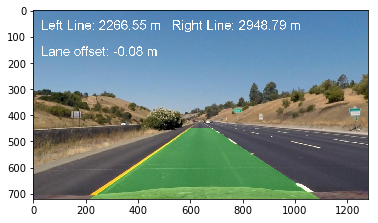

In [19]:
#str1 = 'Left Line:    ' + str(curverad[0]) + 'm'
str1 = 'Left Line: ' + '{:.2f}'.format(curverad[0])      + ' m'
str2 = 'Right Line: ' + '{:.2f}'.format(curverad[1])      + ' m'
str3 = 'Lane offset: '  + '{:.2f}'.format(Test_result[2])   + ' m'



output_image_name = 'test_images_output/' + 'straight_lines1' + '_output' + '.jpg'
    
im = Image.fromarray(Test_result[0])
im.save(output_image_name)

img = Image.open(output_image_name)
font_type = ImageFont.truetype("Arial.ttf",50)

drawn = ImageDraw.Draw(img)
drawn.text(xy=(30,30),text=str1, fill=(255,255,255), font=font_type)
drawn.text(xy=(530,30),text=str2, fill=(255,255,255), font=font_type)
drawn.text(xy=(30,130),text=str3, fill=(255,255,255), font=font_type)

plt.imshow(img)  

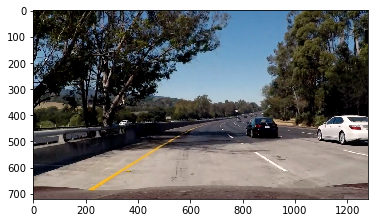

In [20]:
### TEST 2

#reading an image
image2 = mpimg.imread('test_images/test5.jpg')
plt.imshow(image2)  

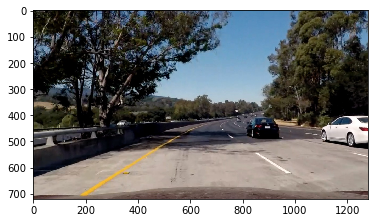

In [21]:
# Undistorted image 2

undist2, mtx2, dist2 = cal_undistort(image2, objpoints, imgpoints)
plt.imshow(undist2) 

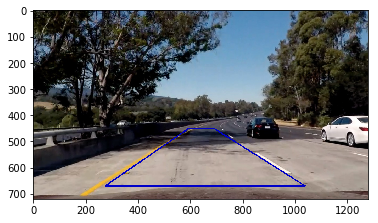

In [22]:
image_copy2 = np.copy(undist2)
image_draw2 = cv2.polylines(image_copy2, vertices, 255, [0,0,200], thickness=3,  lineType=4)

plt.imshow(image_draw2) 

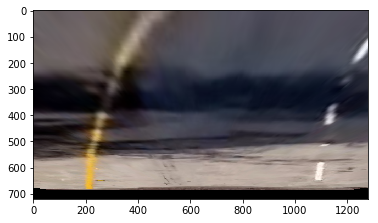

In [23]:
warped_im2, Minv2 = warp(undist2,A,B,C,D)
plt.imshow(warped_im2) 

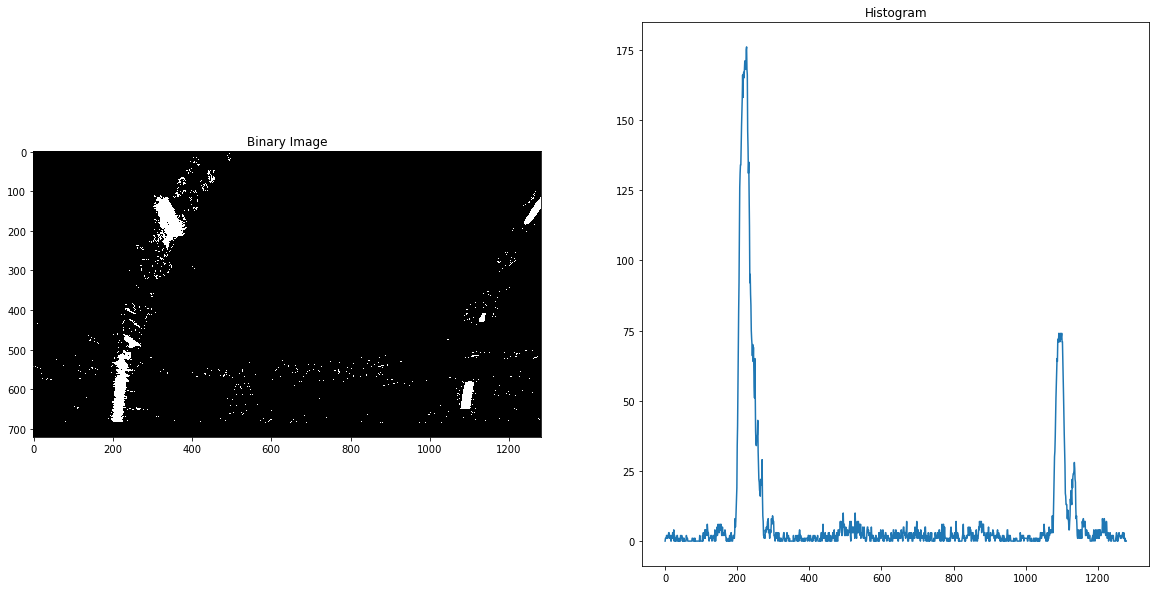

In [24]:
binary_warped2 = My_threshold(warped_im2, ksize=3, Plot=True)

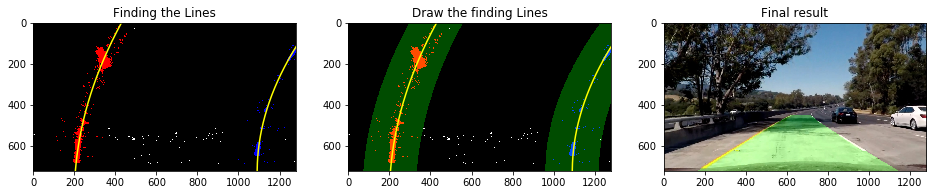

In [25]:
Test2_result = finding_the_Lines(undist2, binary_warped2, Minv2, plot=True)

In [26]:
### OFFSET AND CURVATURE


# OFFSET
print ("Lane offset: ", Test2_result[2])
print ("")


# CURVATURE
curverad2 = measure_curve(Test2_result[-3],Test2_result[-2],Test2_result[-1])

print ('Radius of curvature in meters (m): ')
print ('Left Line: ', curverad2[0], 'm')
print ('Right Line: ', curverad2[1], 'm')### TEST 2

Lane offset:  -0.0431445683322

Radius of curvature in meters (m): 
Left Line:  648.133519217 m
Right Line:  408.843766148 m


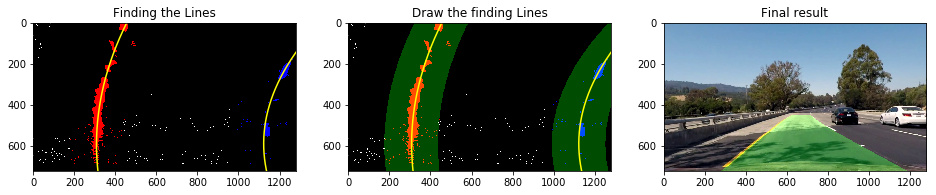

In [27]:
### TEST 3

#reading an image
image3 = mpimg.imread('input_images/image990.jpg')
undist3, mtx3, dist3 = cal_undistort(image3, objpoints, imgpoints)
warped_im3, Minv3 = warp(undist3,A,B,C,D)
binary_warped3 = My_threshold(warped_im3, ksize=3, Plot=False)
Test3_result = finding_the_Lines(undist3, binary_warped3, Minv3, plot=True)

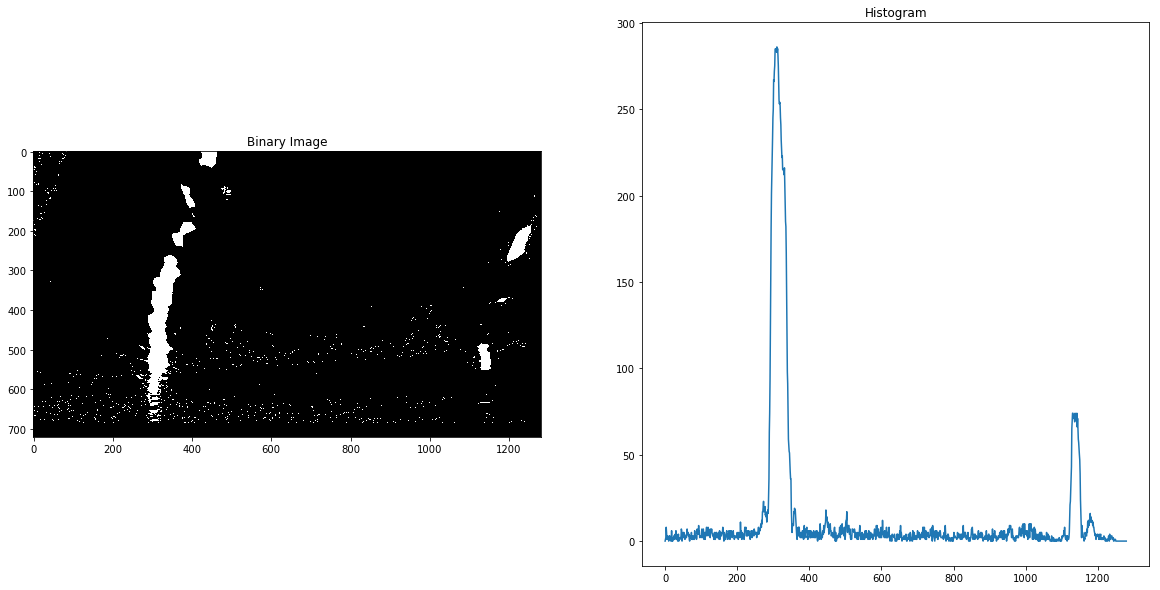

In [28]:
binary_warped3 = My_threshold(warped_im3, ksize=3, Plot=True)

In [29]:
### ALL TEST IMAGES

straight1 = mpimg.imread('test_images/straight_lines1.jpg')
straight2 = mpimg.imread('test_images/straight_lines2.jpg')
test1 = mpimg.imread('test_images/test1.jpg')
test2 = mpimg.imread('test_images/test2.jpg')
test3 = mpimg.imread('test_images/test3.jpg')
test4 = mpimg.imread('test_images/test4.jpg')
test5 = mpimg.imread('test_images/test5.jpg')
test6 = mpimg.imread('test_images/test6.jpg')

#
straight1_undist, straight1_mtx, straight1_dist = cal_undistort(straight1, objpoints, imgpoints)
straight2_undist, straight2_mtx, straight2_dist = cal_undistort(straight2, objpoints, imgpoints)
test1_undist, test1_mtx, test1_dist             = cal_undistort(test1, objpoints, imgpoints)
test2_undist, test2_mtx, test2_dist             = cal_undistort(test2, objpoints, imgpoints)
test3_undist, test3_mtx, test3_dist             = cal_undistort(test3, objpoints, imgpoints)
test4_undist, test4_mtx, test4_dist             = cal_undistort(test4, objpoints, imgpoints)
test5_undist, test5_mtx, test5_dist             = cal_undistort(test5, objpoints, imgpoints)
test6_undist, test6_mtx, test6_dist             = cal_undistort(test6, objpoints, imgpoints)

#
warped_straight1, Minv = warp(straight1_undist,A,B,C,D)
warped_straight1, Minv = warp(straight2_undist,A,B,C,D)
warped_test1, Minv     = warp(test1_undist,A,B,C,D)
warped_test2, Minv     = warp(test2_undist,A,B,C,D)
warped_test3, Minv     = warp(test3_undist,A,B,C,D)
warped_test4, Minv     = warp(test4_undist,A,B,C,D)
warped_test5, Minv     = warp(test5_undist,A,B,C,D)
warped_test6, Minv     = warp(test6_undist,A,B,C,D)


#
binary_warp_straight1 = My_threshold(warped_straight1, ksize=3, Plot=False)
binary_warp_straight2 = My_threshold(warped_straight1, ksize=3, Plot=False)
binary_warp_test1     = My_threshold(warped_test1, ksize=3, Plot=False)
binary_warp_test2     = My_threshold(warped_test2, ksize=3, Plot=False)
binary_warp_test3     = My_threshold(warped_test3, ksize=3, Plot=False)
binary_warp_test4     = My_threshold(warped_test4, ksize=3, Plot=False)
binary_warp_test5     = My_threshold(warped_test5, ksize=3, Plot=False)
binary_warp_test6     = My_threshold(warped_test6, ksize=3, Plot=False)


#
result_straight1 = finding_the_Lines(straight1_undist, binary_warp_straight1,Minv, plot=False)
curverad = measure_curve(result_straight1[-3], result_straight1[-2], result_straight1[-1])
output_image_name = 'test_images_output/' + 'result_straight1.jpg'
im = Image.fromarray(result_straight1[0])
im.save(output_image_name)
im = Image.open(output_image_name) 
str1 = 'Left Line:    ' + '{:.2f}'.format(curverad[0])      + ' m'
str2 = 'Right Line:   ' + '{:.2f}'.format(curverad[1])      + ' m'
str3 = 'Lane offset: '  + '{:.2f}'.format(result_straight1[2])      + ' m'
drawn = ImageDraw.Draw(im)
drawn.text(xy=(30,30),text=str1, fill=(255,255,255), font=font_type)
drawn.text(xy=(670,30),text=str2, fill=(255,255,255), font=font_type)
drawn.text(xy=(30,130),text=str3, fill=(255,255,255), font=font_type)
im.save(output_image_name)



result_straight2 = finding_the_Lines(straight2_undist, binary_warp_straight2,Minv, plot=False)
curverad = measure_curve(result_straight2[-3], result_straight2[-2], result_straight2[-1])
output_image_name = 'test_images_output/' + 'result_straight2.jpg'
im = Image.fromarray(result_straight2[0])
im.save(output_image_name)
im = Image.open(output_image_name) 
str1 = 'Left Line:    ' + '{:.2f}'.format(curverad[0])      + ' m'
str2 = 'Right Line:   ' + '{:.2f}'.format(curverad[1])      + ' m'
str3 = 'Lane offset: '  + '{:.2f}'.format(result_straight2[2])      + ' m'
drawn = ImageDraw.Draw(im)
drawn.text(xy=(30,30),text=str1, fill=(255,255,255), font=font_type)
drawn.text(xy=(670,30),text=str2, fill=(255,255,255), font=font_type)
drawn.text(xy=(30,130),text=str3, fill=(255,255,255), font=font_type)
im.save(output_image_name)


result_test1     = finding_the_Lines(test1_undist, binary_warp_test1, Minv, plot=False)
curverad = measure_curve(result_test1[-3], result_test1[-2], result_test1[-1])
output_image_name = 'test_images_output/' + 'result_test1.jpg'
im = Image.fromarray(result_test1[0])
im.save(output_image_name)
im = Image.open(output_image_name) 
str1 = 'Left Line:    ' + '{:.2f}'.format(curverad[0])      + ' m'
str2 = 'Right Line:   ' + '{:.2f}'.format(curverad[1])      + ' m'
str3 = 'Lane offset: '  + '{:.2f}'.format(result_straight1[2])      + ' m'
drawn = ImageDraw.Draw(im)
drawn.text(xy=(30,30),text=str1, fill=(255,255,255), font=font_type)
drawn.text(xy=(670,30),text=str2, fill=(255,255,255), font=font_type)
drawn.text(xy=(30,130),text=str3, fill=(255,255,255), font=font_type)
im.save(output_image_name)


result_test2     = finding_the_Lines(test2_undist, binary_warp_test2, Minv, plot=False)
curverad = measure_curve(result_test2[-3], result_test2[-2], result_test2[-1])
output_image_name = 'test_images_output/' + 'result_test2.jpg'
im = Image.fromarray(result_test2[0])
im.save(output_image_name)
im = Image.open(output_image_name) 
str1 = 'Left Line:    ' + '{:.2f}'.format(curverad[0])      + ' m'
str2 = 'Right Line:   ' + '{:.2f}'.format(curverad[1])      + ' m'
str3 = 'Lane offset: '  + '{:.2f}'.format(result_test2[2])      + ' m'
drawn = ImageDraw.Draw(im)
drawn.text(xy=(30,30),text=str1, fill=(255,255,255), font=font_type)
drawn.text(xy=(670,30),text=str2, fill=(255,255,255), font=font_type)
drawn.text(xy=(30,130),text=str3, fill=(255,255,255), font=font_type)
im.save(output_image_name)


result_test3 = finding_the_Lines(test3_undist, binary_warp_test3, Minv, plot=False)
curverad = measure_curve(result_test3[-3], result_test3[-2], result_test3[-1])
output_image_name = 'test_images_output/' + 'result_test3.jpg'
im = Image.fromarray(result_test3[0])
im.save(output_image_name)
im = Image.open(output_image_name) 
str1 = 'Left Line:    ' + '{:.2f}'.format(curverad[0])      + ' m'
str2 = 'Right Line:   ' + '{:.2f}'.format(curverad[1])      + ' m'
str3 = 'Lane offset: '  + '{:.2f}'.format(result_test3[2])      + ' m'
drawn = ImageDraw.Draw(im)
drawn.text(xy=(30,30),text=str1, fill=(255,255,255), font=font_type)
drawn.text(xy=(670,30),text=str2, fill=(255,255,255), font=font_type)
drawn.text(xy=(30,130),text=str3, fill=(255,255,255), font=font_type)
im.save(output_image_name)


result_test4 = finding_the_Lines(test4_undist, binary_warp_test4, Minv, plot=False)
curverad = measure_curve(result_test4[-3], result_test4[-2], result_test4[-1])
output_image_name = 'test_images_output/' + 'result_test4.jpg'
im = Image.fromarray(result_test4[0])
im.save(output_image_name)
im = Image.open(output_image_name) 
str1 = 'Left Line:    ' + '{:.2f}'.format(curverad[0])      + ' m'
str2 = 'Right Line:   ' + '{:.2f}'.format(curverad[1])      + ' m'
str3 = 'Lane offset: '  + '{:.2f}'.format(result_test4[2])      + ' m'
drawn = ImageDraw.Draw(im)
drawn.text(xy=(30,30),text=str1, fill=(255,255,255), font=font_type)
drawn.text(xy=(670,30),text=str2, fill=(255,255,255), font=font_type)
drawn.text(xy=(30,130),text=str3, fill=(255,255,255), font=font_type)
im.save(output_image_name)


result_test5     = finding_the_Lines(test5_undist, binary_warp_test5, Minv, plot=False)
curverad = measure_curve(result_test5[-3], result_test5[-2], result_test5[-1])
output_image_name = 'test_images_output/' + 'result_test5.jpg'
im = Image.fromarray(result_test5[0])
im.save(output_image_name)
im = Image.open(output_image_name) 
str1 = 'Left Line:    ' + '{:.2f}'.format(curverad[0])      + ' m'
str2 = 'Right Line:   ' + '{:.2f}'.format(curverad[1])      + ' m'
str3 = 'Lane offset: '  + '{:.2f}'.format(result_test5[2])      + ' m'
drawn = ImageDraw.Draw(im)
drawn.text(xy=(30,30),text=str1, fill=(255,255,255), font=font_type)
drawn.text(xy=(670,30),text=str2, fill=(255,255,255), font=font_type)
drawn.text(xy=(30,130),text=str3, fill=(255,255,255), font=font_type)
im.save(output_image_name)


result_test6= finding_the_Lines(test6_undist, binary_warp_test6, Minv, plot=False)
curverad = measure_curve(result_test6[-3], result_test6[-2], result_test6[-1])
output_image_name = 'test_images_output/' + 'result_test6.jpg'
im = Image.fromarray(result_test6[0])
im.save(output_image_name)
im = Image.open(output_image_name) 
str1 = 'Left Line:    ' + '{:.2f}'.format(curverad[0])      + ' m'
str2 = 'Right Line:   ' + '{:.2f}'.format(curverad[1])      + ' m'
str3 = 'Lane offset: '  + '{:.2f}'.format(result_test6[2])      + ' m'
drawn = ImageDraw.Draw(im)
drawn.text(xy=(30,30),text=str1, fill=(255,255,255), font=font_type)
drawn.text(xy=(670,30),text=str2, fill=(255,255,255), font=font_type)
drawn.text(xy=(30,130),text=str3, fill=(255,255,255), font=font_type)
im.save(output_image_name)

## Processing all frames from the video

In [30]:
### SAVE THE FRAMESIN THE FOLDER 'input_images/'

#pipeline_images = video_to_frames('project_video.mp4', 'input_images/')

In [31]:
### PROCESS ALL IMAGES

# Previous lane image
previous_left_fit = None
previous_right_fit = None
previous_lane_image = None

font_type = ImageFont.truetype("Arial.ttf",40)    

input_images = []

count = 0
for i in range(1257):
    image_name = 'input_images/image' + str(count) + '.jpg'
    input_images.append(image_name)
    #print (image_name)
    count = count + 1

count = 0
for fname in input_images:
    # Read the frame
    frame = mpimg.imread(fname) # array image
    
    # Undistorted image
    undist, mtx, dist = cal_undistort(frame, objpoints, imgpoints)
    
    # Perspective Transform
    warped_im, Minv = warp(undist,A,B,C,D)
    
    
    # Compute binary undistorted images and save it
    binary_undist = My_threshold(undist, ksize=3)
    #binary_undist_name = 'binary_warped_images/' + 'binary_undist' + str(count) + '.jpg'
    #im = Image.fromarray(binary_warped)
    #im.save(binary_undist_name)
    
    # Compute binary warped and undistorted images and save it
    binary_warped = My_threshold(warped_im, ksize=3)
    #binary_warped_name = 'binary_warped_images/' + 'binary_warped' + str(count) + '.jpg'
    #im = Image.fromarray(binary_warped)
    #im.save(binary_warped_name)
    
    # Second, third, ... last frame
    if count != 0:
        final_image, lane_image, lane_offset, detected, left_fit, right_fit, left_fitx, right_fitx, ploty = finding_the_Lines(undist, binary_warped, Minv,
                                                                                          first_frame=False,
                                                                                          previous_lane_image=previous_lane_image,
                                                                                          previous_lane_detected=previous_lane_detected,
                                                                                          previous_left_fit = previous_left_fit,
                                                                                          previous_right_fit=previous_right_fit,                      
                                                                                          plot=False)
    else:
        # First Frame
        final_image, lane_image, lane_offset, detected, left_fit, right_fit,left_fitx, right_fitx, ploty = finding_the_Lines(undist, binary_warped, Minv,
                                                                                          first_frame=True,
                                                                                          previous_lane_image=previous_lane_image,
                                                                                          previous_lane_detected=False,
                                                                                          previous_left_fit = None,
                                                                                          previous_right_fit=None,                      
                                                                                          plot=False)
    
    curverad = measure_curve(left_fitx, right_fitx, ploty)
    
    previous_lane_image = lane_image
    previous_left_fit = left_fit
    previous_right_fit = right_fit
    previous_lane_detected = detected
    
    im = Image.fromarray(final_image)
    
    
    output_image_name = 'output_images/' + 'image' + str(count) + '.jpg'
    im.save(output_image_name)
    
    im = Image.open(output_image_name)  
    
    
    # Write Lane offset and Curvature in the image
    
    str1 = 'Left Line:    ' + '{:.2f}'.format(curverad[0])      + ' m'
    str2 = 'Right Line:   ' + '{:.2f}'.format(curverad[1])      + ' m'
    str3 = 'Lane offset: '  + '{:.2f}'.format(lane_offset)      + ' m'

    drawn = ImageDraw.Draw(im)
    drawn.text(xy=(30,30),text=str1, fill=(255,255,255), font=font_type)
    drawn.text(xy=(530,30),text=str2, fill=(255,255,255), font=font_type)
    drawn.text(xy=(30,130),text=str3, fill=(255,255,255), font=font_type)
    
    im.save(output_image_name)
    count = count + 1


In [32]:
### MAKE A VIDEO

from moviepy.editor import VideoFileClip
from IPython.display import HTML
from moviepy.editor import ImageSequenceClip

In [33]:
output_images = []

count = 0
for i in range(1257):
    image_name = 'output_images/image' + str(count) + '.jpg'
    output_images.append(image_name)
    count = count + 1

In [34]:
seq = ImageSequenceClip(output_images, fps=25)

In [35]:
video_file = 'myvideo' + '.mp4'
seq.write_videofile(video_file)


MoviePy: building video file myvideo.mp4
----------------------------------------

Writing video into myvideo.mp4


100%|██████████████████████████████████████████████████████████████████████████████████| 1207/1207 [01:06<00:00, 18.42it/s]


Done writing video in myvideo.mp4 !
Your video is ready !


In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="myvideo.mp4" type="video/mp4">
</video>
""")